## **Uczenie nadzorowane - inne algorytmy**

Poza poznanymi dotąd sieciami neuronowymi, w uczeniu nadzorowanym (ang. *supervised learning*) stosuje się szeroki wachlarz innych algorytmów, które znajdują zastosowanie zarówno w zadaniach klasyfikacji, jak i regresji (aproksymacji).

Celem tego notatnika jest przedstawienie wybranych klasycznych metod uczenia nadzorowanego wykorzystywanych w problemach klasyfikacyjnych. Zaprezentowane zostaną następujące algorytmy:

- **Drzewa decyzyjne** (*Decision Trees*),
- **Lasy losowe** (*Random Forests*),
- **Maszyny wektorów nośnych** (*Support Vector Machines*, SVM),
- **Metoda k najbliższych sąsiadów** (*k-Nearest Neighbors*, k-NN).

Zostaną one przetestowane na zbiorze danych `wine`, dostępnym w bibliotece *scikit-learn*.

Dane te pochodzą z analizy chemicznej win uprawianych w tym samym regionie Włoch, lecz należących do trzech różnych odmian. Dla każdego wina określono zawartość 13 składników chemicznych.

Dokładny opis zbioru danych można znaleźć pod adresem:  
[https://archive.ics.uci.edu/dataset/109/wine](https://archive.ics.uci.edu/dataset/109/wine)

In [ ]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

#przygotowanie zbioru danych wine
data = load_wine()
X = data.data
y = data.target

#podział zbioru na dane uczące i testujące
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Drzewa decyzyjne

Drzewa decyzyjne mogą być stosowane zarówno do zadań klasyfikacji, jak i aproksymacji (regresji).

Posługując się terminologią z zakresu teorii grafów, drzewo decyzyjne to graf skierowany, acykliczny i spójny, posiadający jeden wyróżniony wierzchołek — korzeń. Korzeń umieszczony jest u góry, a drzewo „rośnie w dół”, odwrotnie niż w przypadku drzew rzeczywistych. W korzeniu znajduje się cały zbiór uczący, który jest stopniowo dzielony w kolejnych węzłach drzewa, aż do osiągnięcia końcowych liści.

Proces predykcji polega na przechodzeniu przez kolejne węzły drzewa w zależności od wyników porównań wartości cech (atrybutów) próbki z progami wyuczonymi podczas treningu. Na każdym etapie porównanie decyduje, czy należy przejść do lewego, czy prawego dziecka danego węzła. Gdy próbka dotrze do liścia, przypisywana jest jej decyzja — najczęściej poprzez wybranie klasy większościowej w danym liściu (dla klasyfikacji) lub średniej wartości (dla regresji).

Drzewa decyzyjne nie wymagają normalizacji danych wejściowych, ponieważ nie opierają się na propagacji wstecznej i posiadają niewielką liczbę parametrów do optymalizacji.

Wadą tej metody jest silna tendencja do **przeuczania się** (ang. *overfitting*), zwłaszcza w przypadku drzew o dużej głębokości.


In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier() # tworzenie drzewa decyzyjnego

In [ ]:
#uczymy model
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
#sprawdzamy dokładność naszej klasyfikacji za pomocą accuracy
from sklearn.metrics import accuracy_score

#dokładność na zbiorze testowym
accuracy_score(y_test, model.predict(X_test))

0.8888888888888888

In [ ]:
#dokładność na zbiorze uczącym
accuracy_score(y_train, model.predict(X_train))

1.0

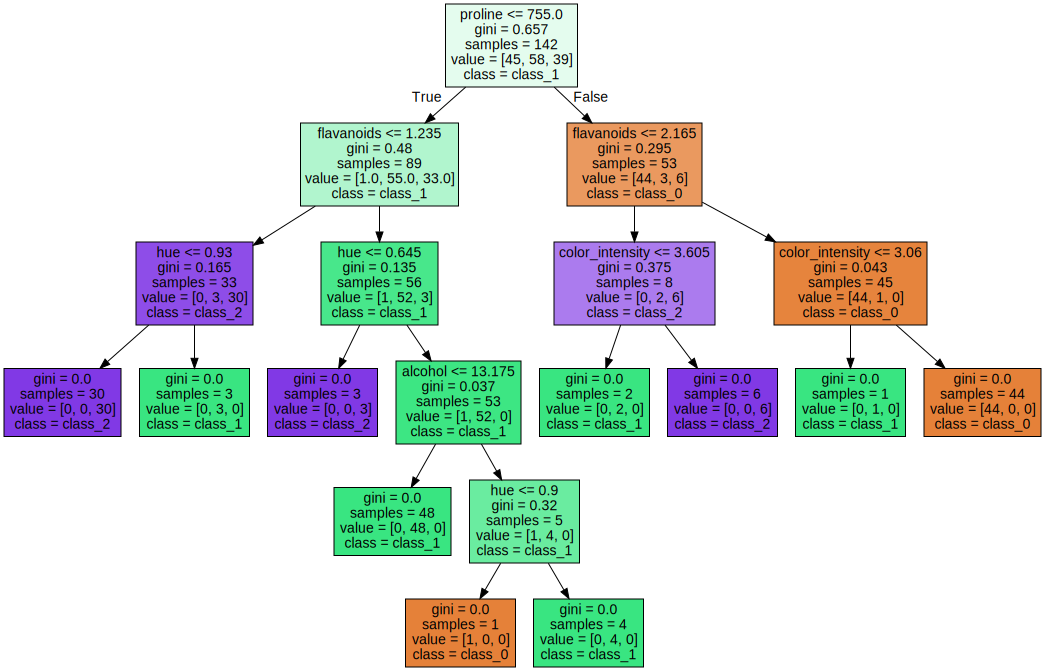

In [ ]:
import graphviz #importy potrzebne do wizualizacji drzewa decyzyjnego
from sklearn import tree

#wizualizacja modelu drzewa decyzyjnego dla nauczonego algorytmu
dot_decision_tree = tree.export_graphviz(model, out_file=None, feature_names=data.feature_names,
                                         class_names=data.target_names, filled=True)
decision_tree_plot = graphviz.Source(dot_decision_tree, format='png')
decision_tree_plot

### Ograniczanie przeuczenia — przycinanie drzewa

Jednym ze sposobów przeciwdziałania przeuczeniu drzew decyzyjnych jest tzw. *przycinanie* (ang. *pruning*), czyli ograniczanie ich złożoności.

Drzewa decyzyjne posiadają szereg parametrów, za pomocą których można kontrolować ich rozrost. Do najważniejszych należą:

- `max_depth` — maksymalna głębokość drzewa,
- `min_samples_split` — minimalna liczba próbek wymagana do podziału węzła,
- `min_samples_leaf` — minimalna liczba próbek w liściu,
- `max_features` — maksymalna liczba cech brana pod uwagę przy podziale.

Szczegółowy opis tych parametrów znajduje się w [oficjalnej dokumentacji scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

Poniżej zaprezentowano przykład utworzenia drzewa decyzyjnego na zbiorze `wine`, z ograniczoną głębokością drzewa — co pozwala lepiej zobrazować działanie mechanizmu przycinania.


In [ ]:
#tworzymy model drzewa decyzyjnego, tym razem z określoną, tym razem względnie płytki
model = DecisionTreeClassifier(max_depth=3)

#uczymy model
model.fit(X_train, y_train)

#dokładność na zbiorze testowym
print(accuracy_score(y_test, model.predict(X_test)))
#dokładność na zbiorze uczącym
print(accuracy_score(y_train, model.predict(X_train)))

0.8888888888888888
0.9929577464788732


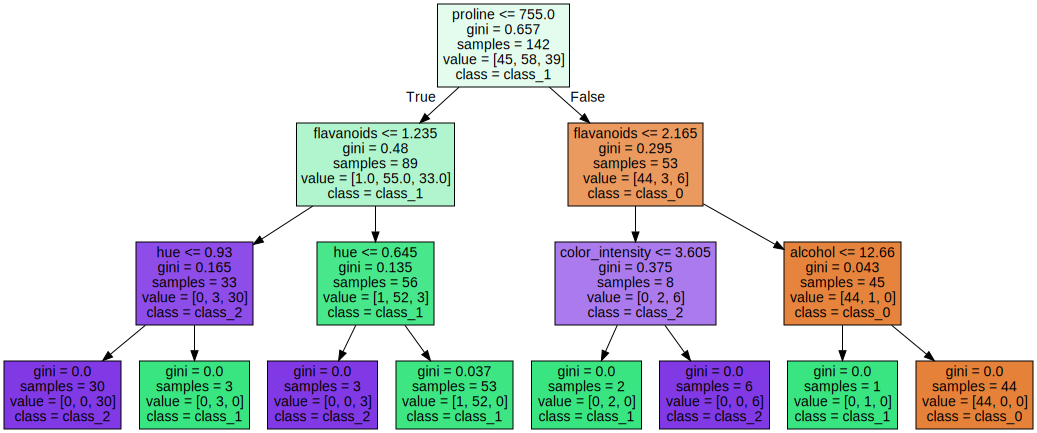

In [ ]:
dot_decision_tree = tree.export_graphviz(model, out_file=None, feature_names=data.feature_names,
                                         class_names=data.target_names, filled=True)
decision_tree_plot = graphviz.Source(dot_decision_tree, format='png')
decision_tree_plot

### Lasy losowe

Lasy losowe to algorytm zespołowy (*ensemble method*), zbudowany z wielu klasyfikatorów — zazwyczaj drzew decyzyjnych. Nazwa pochodzi od „lasu” tych drzew, które wspólnie podejmują decyzję.

Algorytm ten polega na budowaniu wielu drzew decyzyjnych, z których każde trenowane jest na innym, losowo wybranym podzbiorze danych uczących (technika baggingu). Dzięki temu model cechuje się niższą tendencją do przeuczania się w porównaniu z pojedynczym drzewem, ponieważ nie wszystkie drzewa widzą te same dane.

Decyzja końcowa w przypadku klasyfikacji podejmowana jest poprzez głosowanie większościowe — wybrana zostaje ta klasa, którą wskazało najwięcej drzew. W przypadku regresji, przyjmowana jest średnia predykcja wszystkich drzew.

Ponieważ lasy losowe składają się z wielu estymatorów (*estimators* — pojedynczych drzew), ich pełna wizualizacja jest trudna, a czasem niepraktyczna.

Lasy losowe mogą być stosowane zarówno do zadań klasyfikacji, jak i regresji.


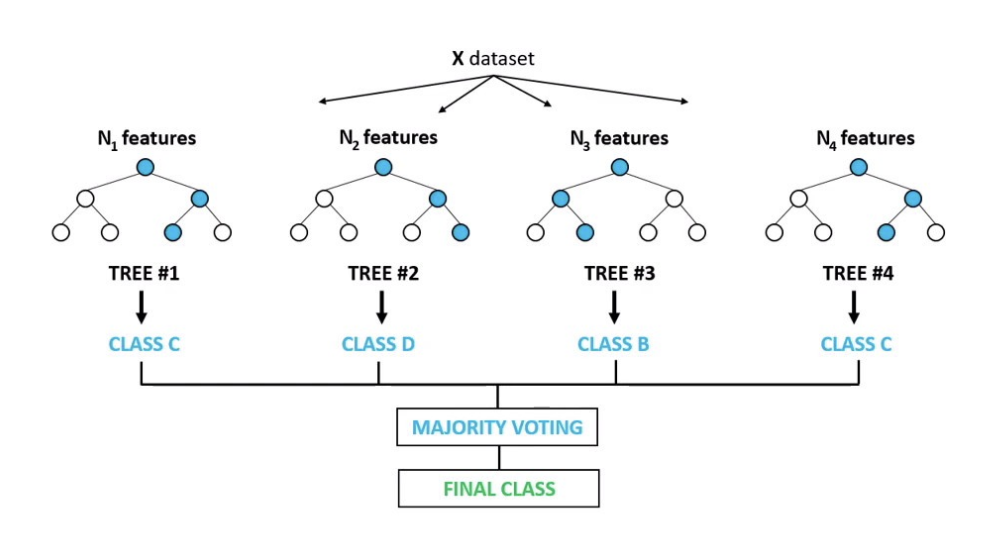

In [ ]:
from sklearn.ensemble import RandomForestClassifier
#tworzymy model lasu losowego, bez określenia jego parameterów (stosowane są wartości domyślne)
model = RandomForestClassifier()
#uczymy model
model.fit(X_train, y_train)
print(accuracy_score(y_test, model.predict(X_test))) #dokładność na zbiorze testowym
print(accuracy_score(y_train, model.predict(X_train))) #dokładność na zbiorze uczącym

0.9722222222222222
1.0


### Parametry lasów losowych

Ponieważ lasy losowe stanowią „zespół” drzew, konieczne jest określenie liczby estymatorów, czyli liczby drzew w lesie — parametr ten nazywa się `n_estimators`.

Pozostałe parametry są bardzo podobne do tych stosowanych w pojedynczych drzewach decyzyjnych, takie jak `max_depth`, `min_samples_split`, `min_samples_leaf` czy `max_features`.

Szczegółowy opis wszystkich parametrów znajduje się w [dokumentacji scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).


In [ ]:
#stworzmy w takim razie model lasu losowego, tym razem zawierajacy 50 drzew, każde o głębokości 3
model = RandomForestClassifier(n_estimators=50, max_depth=3)
#uczymy model
model.fit(X_train, y_train)
print(accuracy_score(y_test, model.predict(X_test))) #dokładność na zbiorze testowym
print(accuracy_score(y_train, model.predict(X_train))) #dokładność na zbiorze uczącym

0.9722222222222222
1.0


### Lepsza generalizacja dzięki wielu drzewom

W eksperymencie przeprowadzonym na badanym zbiorze danych zaobserwowano, że użycie dużej liczby **płytkich** drzew w lesie losowym przynosi lepsze rezultaty niż pojedyncze drzewo decyzyjne.

Model osiągał **wyższe wartości metryki accuracy**, a jednocześnie różnica pomiędzy wynikami na zbiorze treningowym i testowym **zmniejszyła się**. Oznacza to, że model lepiej uogólnia dane, a więc charakteryzuje się **lepszą generalizacją**.

W przeciwieństwie do pojedynczego drzewa, las losowy w tym przypadku **nie przeuczył się**, co potwierdza skuteczność metody zespołowej w ograniczaniu przeuczenia.


## SVM (Support Vector Machine, maszyna wektorów nośnych)

SVM to algorytm uczenia nadzorowanego, którego celem jest znalezienie optymalnej hiperpłaszczyzny oddzielającej dane należące do różnych klas, przy maksymalnym marginesie separacji.

Margines to odległość tej hiperpłaszczyzny od najbliższych punktów treningowych, które noszą nazwę wektorów podtrzymujących (ang. *support vectors*). To właśnie te punkty są kluczowe w wyznaczeniu granicy decyzyjnej.

W przypadku danych liniowo separowalnych metoda SVM pozwala na znalezienie prostej (lub w wyższych wymiarach — hiperpłaszczyzny), która rozdziela dane na dwie klasy z możliwie największym marginesem.

SVM może być stosowane zarówno do zadań klasyfikacji, jak i aproksymacji (regresji).

Czasami w starszych źródłach lub materiałach popularnonaukowych można spotkać się z określeniem „sieci neuronowe SVM”. Wynika to z podobieństwa semantycznego — oba podejścia są inspirowane biologiczną ideą uczenia się i działają w ramach algorytmów uczenia maszynowego. Jednak technicznie rzecz biorąc, **SVM nie są sieciami neuronowymi** — nie mają architektury warstwowej ani nie wykorzystują propagacji wstecznej. To zupełnie odrębna klasa modeli.


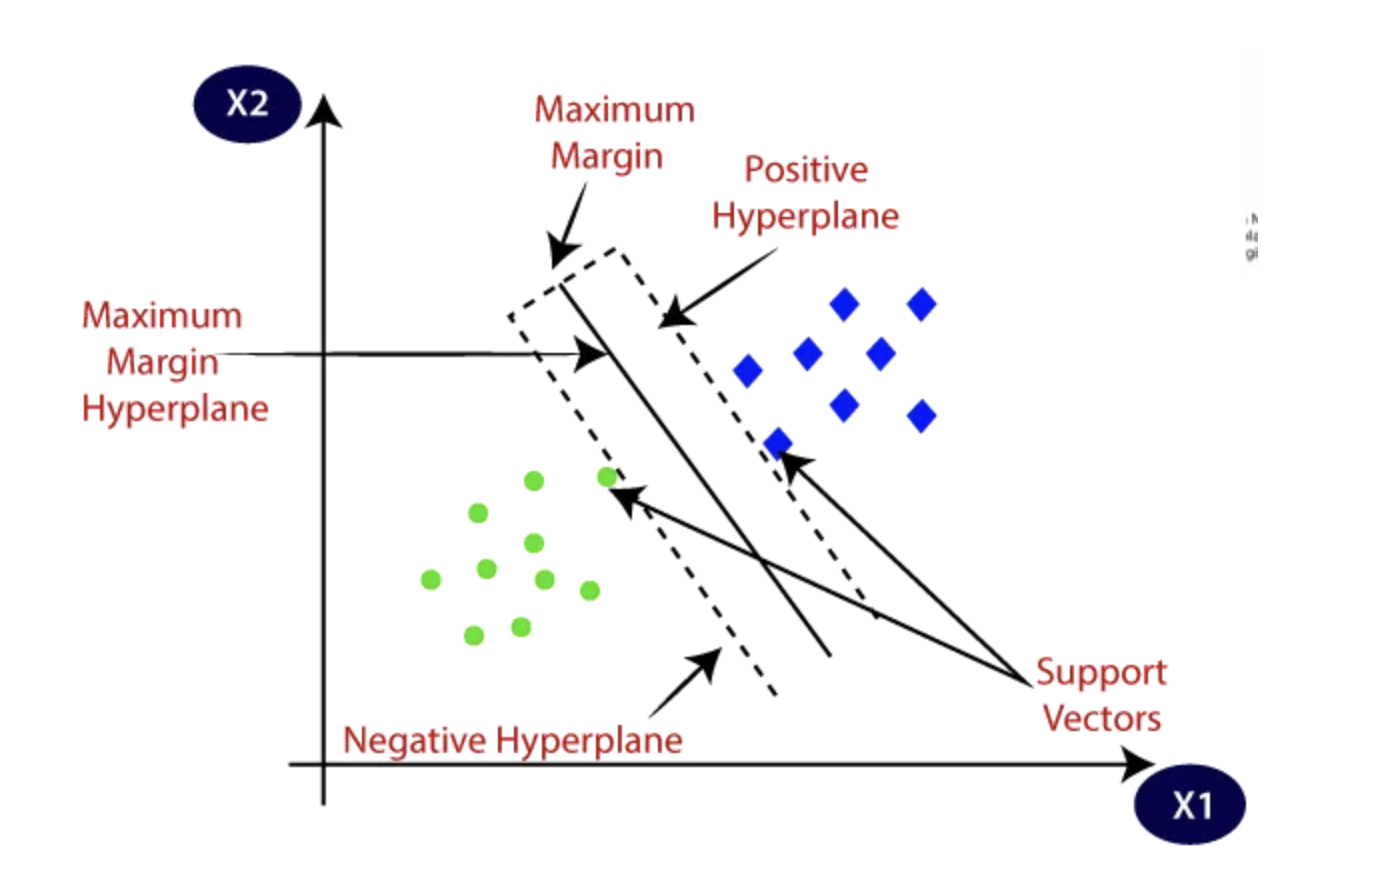

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
#na początek warto zastosować standaryzację danych. Nie jest to konieczne dla SVM, ale zdecydowanie rekomendowane i znacznie poprawia wyniki
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#podział zestandaryzowanego zbioru na dane uczące i testujące
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1)

In [ ]:
model = SVC()
model.fit(X_train, y_train)
print(accuracy_score(y_test, model.predict(X_test))) #dokładność na zbiorze testowym
print(accuracy_score(y_train, model.predict(X_train))) #dokładność na zbiorze uczącym

0.9722222222222222
1.0


## KNN (k-Nearest Neighbours)

Algorytm k-najbliższych sąsiadów (ang. *k-Nearest Neighbours*, KNN) to prosty i intuicyjny algorytm klasyfikacyjny, który opiera się na lokalnym podobieństwie danych.

Aby zaklasyfikować nowy punkt, algorytm analizuje jego **k najbliższych sąsiadów** w przestrzeni cech i przypisuje ten punkt do klasy, która występuje najczęściej wśród tych sąsiadów.

Parametr `k` określa liczbę branych pod uwagę sąsiadów i ma istotny wpływ na zachowanie modelu:
- **Małe k** (np. 1–3) sprawia, że model staje się bardzo czuły na szumy i wartości odstające.
- **Duże k** powoduje, że granice między klasami stają się bardziej rozmyte i mogą ulec wypaczeniu w przypadku niezrównoważonych klas.

Algorytm KNN nie dokonuje żadnego treningu w klasycznym sensie — cała "nauka" polega na zapamiętaniu zbioru uczącego. Predykcja odbywa się dopiero w momencie klasyfikacji nowego punktu i może być kosztowna obliczeniowo przy dużych zbiorach danych.

KNN może być również używany do regresji, jeśli zamiast najczęstszej klasy wyliczana jest średnia wartość cechy ciągłej wśród najbliższych sąsiadów.

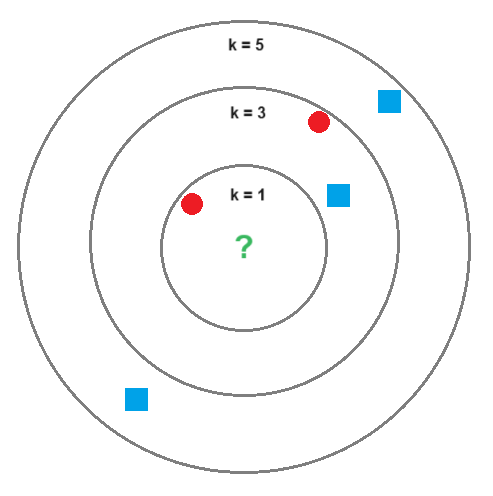

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
#do nauki używamy danych po działaniu scalera
model.fit(X_train, y_train)
print(accuracy_score(y_test, model.predict(X_test))) #dokładność na zbiorze testowym
print(accuracy_score(y_train, model.predict(X_train))) #dokładność na zbiorze uczącym

0.9722222222222222
0.9859154929577465


## Zadania

1.

Proszę pobrać pliki set1.csv i set2.csv. Dla obu proszę zaproponować klasyfikator oparty na każdym zaprezentowanym algorytmie oraz na sieci neuronowej wielowarstwowej (o zaproponowanej przez państwa strukturze). Proszę porównać wyniki i pokazać na rysunku jak przebiegła klasyfikacja w każdym wypadku. Dla drzew decyzyjnych, proszę narysować drzewa powstałe dla obu zbiorów.

Jaki algorytm sprawdzał się najlepiej?


2.

Dla zbioru danych dotyczących raka piersi (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html) proszę zaproponować klasyfikator oparty na każdym zaprezentowanym algorytmie oraz na sieci neuronowej wielowarstwowej (o zaproponowanej przez państwa strukturze). Proszę porównać wyniki.

Dodatkowo proszę o wykonanie wykresów zależności:

- dokładności klasyfikacji w zależności od ilości sąsiadów w algorytmie KNN

- dokładości klasyfikacji drzewa decyzyjnego w zależności od 3 dowolnych parametrów (przykładowo: max_depth, min_samples_split oraz min_samples_leaf).

- dokładności klasyfikacji lasu losowego w zależności od ilości drzew.

Co możemy wnioskować z zaprezentowanych wykresów? Czy wraz z wzrostem "complexity" algorytmu rośnie jego dokładność? W jaki sposób możemy to odnieść do zjawiska przeuczenia?

Jaki algorytm sprawdzał się najlepiej?







## Zadania dla chętnych



Proszę do danych z zadania 2 zastosować jeszcze dodatkowo XGBoost oraz zapoznać się z charakterystyką tego algorytmu.